# Encoder calibration (Elevation / Cross Elevation)

In [1]:
%matplotlib inline
from __future__ import division, print_function
from builtins import zip, range

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.table import Table
from scipy.optimize import leastsq

## Movement of the stars on the sky during the sky test in Toulouse

In [5]:
a = Table.read('/Users/Vincent/owncloud/FireballEurope/Skytest/SkyTest4_Calibration/GondolaV3.fits')
date = map(lambda dh:'-'.join(dh[0].split('/')[::-1])+ ' ' + dh[1],zip(a['date TU'],a['time TU']))
UTC = Time(date,'UTC')

utc1 = Time('2017-06-22 01:11', 'UTC')
utc2 = Time('2017-06-22 01:18', 'UTC')
time_test =(UTC>utc1) & (UTC<utc2)
timesec = (UTC - Time('2017-06-22 00:00', 'UTC')).to('s').value

#HIP = SkyCoord("15h20m05.079s +60d22m49.13s")
#Toulouse = EarthLocation(lat=43.561048*u.deg, lon=1.483655*u.deg, height=200*u.m)
#HIPaltaz = HIP.transform_to(AltAz(obstime=UTC,location = Toulouse))
#a['azHP75042'] = HIPaltaz.az.degree
#a['altHP75042'] = HIPaltaz.alt.degree

## conversion in azimut,elev inside the gondola frame

In [6]:
d2r = np.pi/180.
TNac = -0.3014*d2r
RNac = 0.2199*d2r
AzNac =  317.411285*d2r


Az = a['azHP75042']*d2r 
El = a['altHP75042']*d2r
Az_new = np.arctan2(-(np.cos(TNac)*np.sin(El)*np.sin(RNac)) - np.cos(El)*(-(np.cos(RNac)*np.sin(Az - AzNac)) + 
                                                                        np.cos(Az - AzNac)*np.sin(RNac)*np.sin(TNac)),
                    np.cos(Az - AzNac)*np.cos(El)*np.cos(TNac) - np.sin(El)*np.sin(TNac))
                    
Alt_new = np.arcsin(np.cos(El)*np.sin(
    Az - AzNac)*np.sin(RNac) + \
                    np.cos(RNac)*(np.cos(TNac)*np.sin(El) + np.cos(Az - AzNac)*np.cos(El)*np.sin(TNac)))


a['azHP75042_nac'] = Az_new/d2r
a['altHP75042_nac'] = Alt_new/d2r

<IPython.core.display.Javascript object>


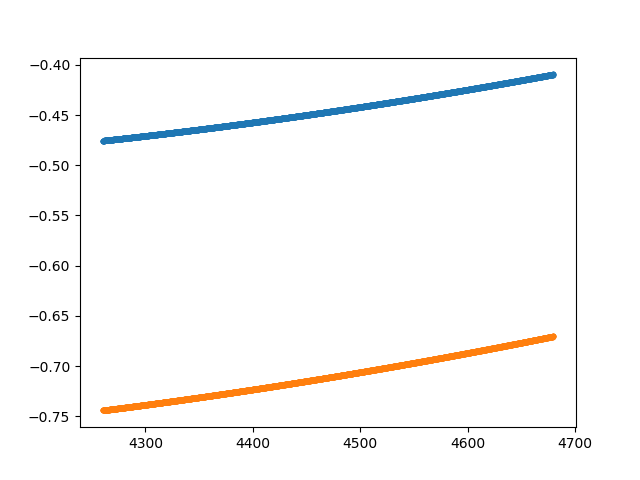

In [7]:
plt.figure()
plt.plot(timesec[time_test], a['azHP75042'][time_test]-AzNac/d2r,'.')
plt.plot(timesec[time_test], a['azHP75042_nac'][time_test],'.')


<IPython.core.display.Javascript object>


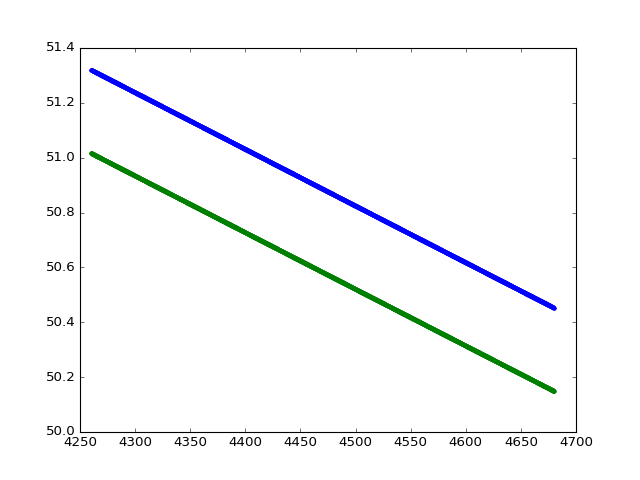

In [18]:
plt.figure()
plt.plot(timesec[time_test], a['altHP75042'][time_test],'.')
plt.plot(timesec[time_test], a['altHP75042_nac'][time_test],'.')


## Linear Regression to determine the slops

We measure the slopes of:
 * The star coordinates (Az,Alt) inside the gondola frame
 * The siderostat angles (elev, Cross-elev)

<IPython.core.display.Javascript object>


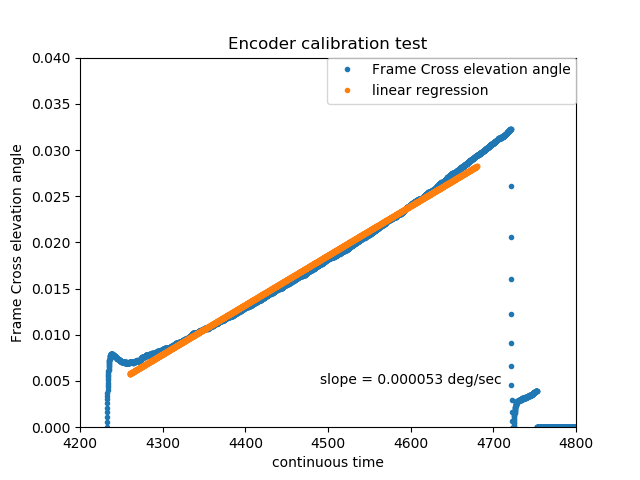

Text(0,0.5,u'Frame Cross elevation angle')

In [8]:
dACE, covACE = np.polyfit(timesec[time_test], a['CeAngleCadre'][time_test], 1, cov='True')
plt.figure()
plt.plot(timesec, a['CeAngleCadre'],'.',label = "Frame Cross elevation angle")
plt.plot(timesec[time_test], dACE[0]*timesec[time_test] + dACE[1],'.' ,label = "linear regression",)
plt.figtext(.5, .2,'slope = %0.6f deg/sec ' % (dACE[0]), fontsize=10)
tlim = 4200,4800
plt.xlim(tlim)
plt.ylim((0,0.04))
plt.title('Encoder calibration test')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('Frame Cross elevation angle')


<IPython.core.display.Javascript object>


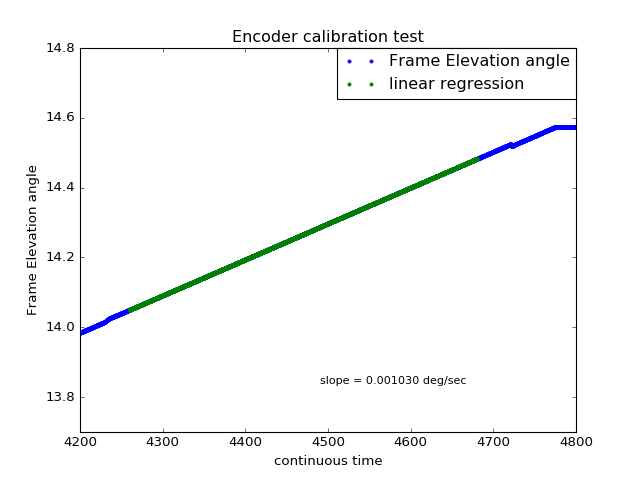

In [20]:
dAEL, covAEL = np.polyfit(timesec[time_test], a['ElAngleCadre'][time_test], 1, cov='True')
plt.figure()
plt.plot(timesec, a['ElAngleCadre'],'.',label = "Frame Elevation angle")
plt.plot(timesec[time_test], dAEL[0]*timesec[time_test] + dAEL[1],'.' ,label = "linear regression",)
plt.figtext(.5, .2,'slope = %0.6f deg/sec ' % (dAEL[0]), fontsize=10)
plt.xlim(tlim)
plt.ylim((13.7,14.8))
plt.title('Encoder calibration test')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('Frame Elevation angle')


<IPython.core.display.Javascript object>


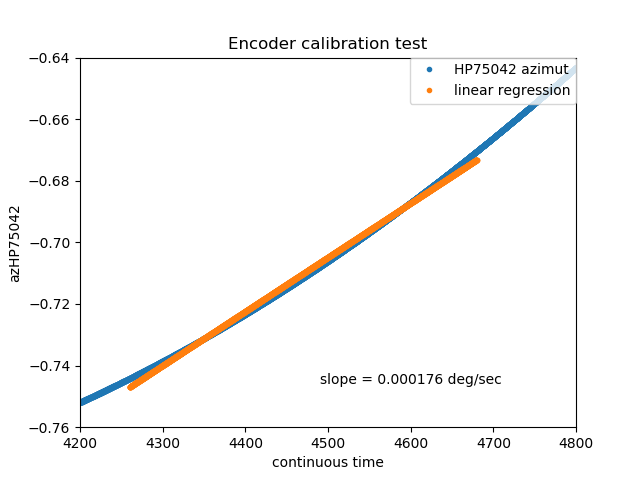

Text(0,0.5,u'azHP75042')

In [9]:
dAz, covAz = np.polyfit(timesec[time_test], a['azHP75042_nac'][time_test], 1, cov='True')
plt.figure()
plt.plot(timesec, a['azHP75042_nac'],'.',label = "HP75042 azimut")
plt.plot(timesec[time_test], dAz[0]*timesec[time_test] + dAz[1],'.' ,label = "linear regression",)
plt.figtext(.5, .2,'slope = %0.6f deg/sec ' % (dAz[0]), fontsize=10)
plt.xlim(tlim)
#plt.ylim((316.9,317.2))
plt.ylim((-0.76,-0.64))
plt.title('Encoder calibration test')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('azHP75042')

<IPython.core.display.Javascript object>


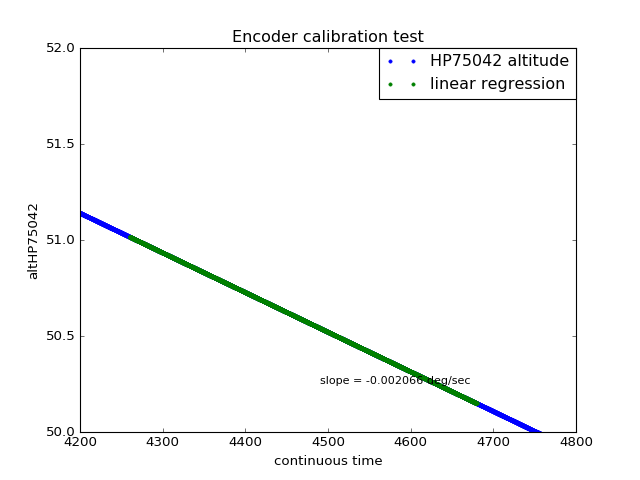

In [22]:
dEl, coEl = np.polyfit(timesec[time_test], a['altHP75042_nac'][time_test], 1, cov='True')

plt.figure()
plt.plot(timesec, a['altHP75042_nac'],'.',label = "HP75042 altitude")
plt.plot(timesec[time_test], dEl[0]*timesec[time_test] + dEl[1],'.' ,label = "linear regression",)
plt.figtext(.5, .2,'slope = %0.6f deg/sec ' % (dEl[0]), fontsize=10)
plt.xlim(tlim)
plt.ylim((50,52))
plt.title('Encoder calibration test')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('altHP75042')



## Compare the theoritical siderostat speed with the measured one 

We assume the star is located at field center, and use equations of the siderostat speed with respect to the field center LOS speed. For that we computed with mathematica the jacobian of the Az,Alt with respect to Elev,Cross-Elev, and inverted it. 

In [17]:
d2r = np.pi/180.
thetamp = thetamp0 = 10*d2r
ACE = np.array(a['CeAngleCadre'][time_test])*d2r
AEl = np.array(a['ElAngleCadre'][time_test])*d2r

def Jacobien_dv_inverse(AEl, ACE, thetamp):
    coef00=-1/2
    coef01 = -np.cos(AEl)*ACE
    coef10 = (-1/np.tan(2*AEl + thetamp) - 1/2*np.tan(AEl + thetamp))*ACE
    coef10 = -1/4*((3*np.cos(AEl)+np.cos(3*AEl+2*thetamp))/np.sin(2*AEl+thetamp)/np.cos(AEl+thetamp))*ACE
    coef11 = 1/2*np.sin(2*AEl + thetamp)/np.cos(AEl+thetamp)

    Jinv = np.stack(np.broadcast(coef00, coef01, coef10, coef11)).reshape(-1,2,2)
    return Jinv

Jinv = Jacobien_dv_inverse(AEl, ACE, thetamp)
print('Jacobien inverse au début:\n{},\n à la fin:\n{}'.format(Jinv[0],Jinv[-1]))

middle = 3500//2
print('\nJacobien inverse au milieu:\n{}'.format(Jinv[middle]))
angle_cor = Jinv[middle].dot([dEl[0], dAz[0]])/np.array([dAEL[0], dACE[0]])
print('facteur de correction sur les angles cadres:\nElev:{}\nCross:{}'.format(angle_cor[0], angle_cor[1]))

Jinv_cor = Jacobien_dv_inverse(AEl*angle_cor[0], ACE*angle_cor[1], thetamp)
print('Jacobien inverse corrigé au milieu:\n{}'.format(Jinv_cor[middle]))
print(dEl[0]/d2r*60,dAz[0]/d2r*60)

Jacobien inverse au début:
[[-5.00000000e-01 -1.18992085e-04]
 [-1.83804134e-04  3.37850933e-01]],
 à la fin:
[[-5.00000000e-01 -4.97058457e-04]
 [-7.51639478e-04  3.45484925e-01]]

Jacobien inverse au milieu:
[[-5.00000000e-01 -2.78539892e-04]
 [-4.25672297e-04  3.41670752e-01]]


NameError: name 'dEl' is not defined

We assume the star is located somewhere in the field, and use equations of the siderostat speed with respect to the star LOS speed. For that we computed with mathematica the jacobian of the Az,Alt with respect to Elev,Cross-Elev, and inverted it. 

In [18]:
alphax0 =  -641.88/3600.*d2r
alphay0 =  -16.596/3600.*d2r
alphax, alphay = alphax0, alphay0
#alphax=0.
#alphay=0.

def Jacobien_etoile_inverse(AEl, ACE, thetamp, alphax, alphay):
    
    dcoef00=ACE*(\
        1/4*(1 + 2*np.cos(2*AEl)+ np.cos(4*AEl + 2*thetamp))/np.sin(2*AEl + thetamp)**2 / np.cos(AEl + thetamp)*alphay 
       -1/16*(9*np.cos(AEl) + 2*np.cos(3*AEl) + 6*np.cos(AEl + 2*thetamp) + 9*np.cos(3*AEl + 2*thetamp) + 
              5*np.cos(5*AEl + 2*thetamp) + np.cos(7*AEl + 4*thetamp))/np.sin(2*AEl + thetamp)**3/np.cos(AEl + thetamp)**2 
             *alphax*alphay)


    dcoef01 = -1/2* np.cos(AEl)/np.cos(AEl + thetamp)*alphay - 1/2*np.cos(AEl)/np.cos(AEl + thetamp)*alphax*alphay*\
    np.tan(AEl + thetamp)

    dcoef10 = ACE*(1/4*(1 + 2*np.cos(2*(AEl + thetamp)) + np.cos(4*AEl + 2*thetamp))/np.sin(2*AEl + thetamp)**2/
                  np.cos(AEl + thetamp)**2 *alphax) -1/2/np.tan(2*AEl + thetamp)/np.cos(AEl + thetamp) * alphay +\
             1/8*(4*np.cos(AEl + thetamp) - np.cos(3*AEl + thetamp) + np.cos(5*AEl + 3*thetamp))/\
             np.sin(2*AEl + thetamp)**2/np.cos(AEl + thetamp)**2 * alphax*alphay
           
    dcoef11 = 1/2*np.cos(AEl)/np.cos(AEl + thetamp)**2*alphax +\
        ACE*(-1/4*np.cos(AEl)*(-3 + np.cos(2*(AEl + thetamp)))/np.cos(AEl + thetamp)**3 *alphax*alphay +\
         1/2*np.cos(AEl)/np.cos(AEl + thetamp)*alphay*np.tan(AEl + thetamp))

    Jinv = Jacobien_dv_inverse(AEl, ACE, thetamp)
    Jinv += np.stack(np.broadcast(dcoef00, dcoef01, dcoef10, dcoef11)).reshape(-1,2,2)
    return Jinv

Jinv = Jacobien_etoile_inverse(AEl, ACE, thetamp, alphax, alphay)
print('Jacobien inverse au début:\n{},\n à la fin:\n{}'.format(Jinv[0],Jinv[-1]))

middle = 3500//2
print('\nJacobien inverse au milieu:\n{}'.format(Jinv[middle]))
angle_cor = Jinv[middle].dot([dEl[0], dAz[0]])/np.array([dAEL[0], dACE[0]])
print('facteur de correction sur les angles cadres:\nElev:{}\nCross:{}'.format(angle_cor[0], angle_cor[1]))

Jinv_cor = Jacobien_etoile_inverse(AEl*angle_cor[0], ACE*angle_cor[1], thetamp, alphax, alphay)
print('Jacobien inverse corrigé au milieu:\n{}'.format(Jinv_cor[middle]))
print('new correction {}'.format(Jinv_cor[middle].dot([dEl[0], dAz[0]])/np.array([dAEL[0], dACE[0]])))

Jacobien inverse au début:
[[-5.00000021e-01 -7.63151378e-05]
 [-1.28112343e-04  3.36040896e-01]],
 à la fin:
[[-5.00000086e-01 -4.54319405e-04]
 [-6.99788295e-04  3.43666020e-01]]

Jacobien inverse au milieu:
[[-5.00000049e-01 -2.35831929e-04]
 [-3.71750463e-04  3.39856302e-01]]


NameError: name 'dEl' is not defined

### Conclusion for speed measurements:
* the **test duration is too long**: the azimut speed is not constant leading to a **jacobian that is not constant**.
* either we split the test to smaller chunks and compute the mean result
* or we directly fit the Azimut,Altitude curves (ie no derivation), using slope and offset corrections for both Elevation and Cross-Elevation siderostat frame angles

## Fitting a residual on Azimut, Altitude

<IPython.core.display.Javascript object>


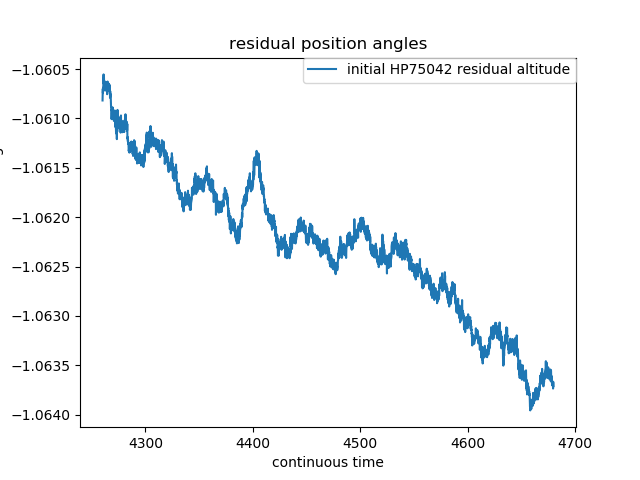

<IPython.core.display.Javascript object>


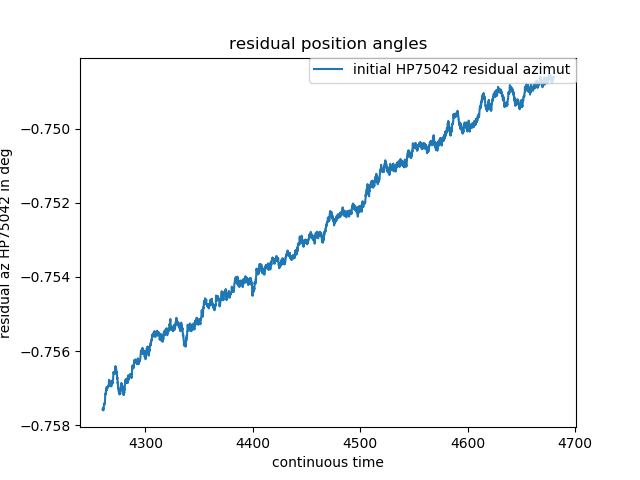

Text(0,0.5,u'residual az HP75042 in deg')

In [19]:
#theoritical star coord
def thAlt(AEl, ACE, thetamp=thetamp0, alphax=alphax0, alphay=alphay0): 
    Alt = np.arcsin(np.cos(alphay)*(np.cos(ACE)**2 * np.cos(2*AEl + thetamp + alphax) - \
             np.cos(thetamp + alphax)*np.sin(ACE)**2) - np.cos(AEl)*np.sin(2*ACE)*np.sin(alphay))
    return Alt 

def thAz(AEl, ACE, thetamp=thetamp0, alphax=alphax0, alphay=alphay0):
    Az = np.arctan2(np.cos(AEl + thetamp + alphax)*np.cos(alphay)*np.sin(2*ACE) + np.cos(2*ACE)*np.sin(alphay),
               np.cos(alphay)*(np.sin(ACE)**2*np.sin(thetamp + alphax) + \
                               np.cos(ACE)**2*np.sin(2*AEl + thetamp + alphax)) - \
                np.sin(2*ACE)*np.sin(AEl)*np.sin(alphay))
    return Az

alt = a['altHP75042_nac'][time_test]*d2r
az = a['azHP75042_nac'][time_test]*d2r

def res(x, AEl=AEl, ACE=ACE, thetamp=thetamp0, alphax=alphax0, alphay=alphay0):
    return alt - thAlt(x[0] + x[1]*AEl, x[2] + x[3]*ACE, thetamp, alphax, alphay), \
            az - thAz(x[0] + x[1]*AEl, x[2] + x[3]*ACE, thetamp, alphax, alphay)


#residual without correction
x0 = np.array([0,1,0,1])
res0Alt, res0Az = res(x0)

plt.figure()
plt.plot(timesec[time_test], res0Alt/d2r,'-',label = "initial HP75042 residual altitude")
plt.title('residual position angles')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('residual alt HP75042 in deg')

plt.figure()
plt.plot(timesec[time_test], res0Az/d2r,'-',label = "initial HP75042 residual azimut")
plt.title('residual position angles')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('residual az HP75042 in deg')



Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000

Solution:
 El offset:      0.47927551819 +-0.000208234917663 in deg
 El linear gain: 1.00353151346 +-1.45956304084e-05
 CE offset:      -0.260808067447 +-3.55072005722e-06 in deg
 CE gain:        0.907004392313 +-0.000195891811817
 
covariance:
 [[  1.32087538e-11  -5.30441079e-11  -2.03754202e-15   6.73628635e-12]
 [ -5.30441079e-11   2.13032427e-10   8.15310640e-15  -2.70440121e-11]
 [ -2.03754202e-15   8.15310640e-15   3.84049852e-15  -1.13328959e-11]
 [  6.73628635e-12  -2.70440121e-11  -1.13328959e-11   3.83736019e-08]]


<IPython.core.display.Javascript object>


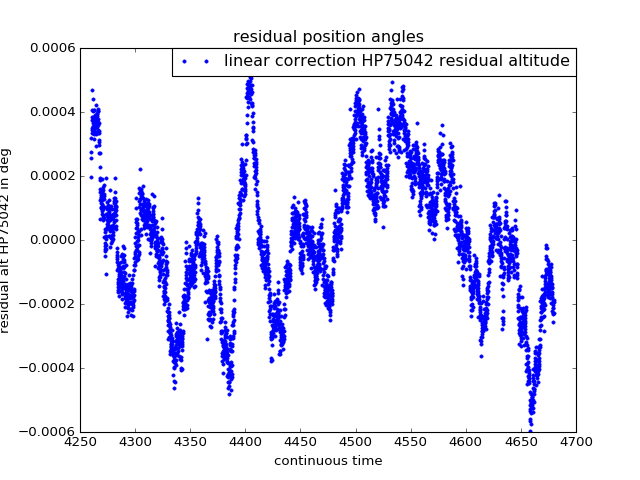

<IPython.core.display.Javascript object>


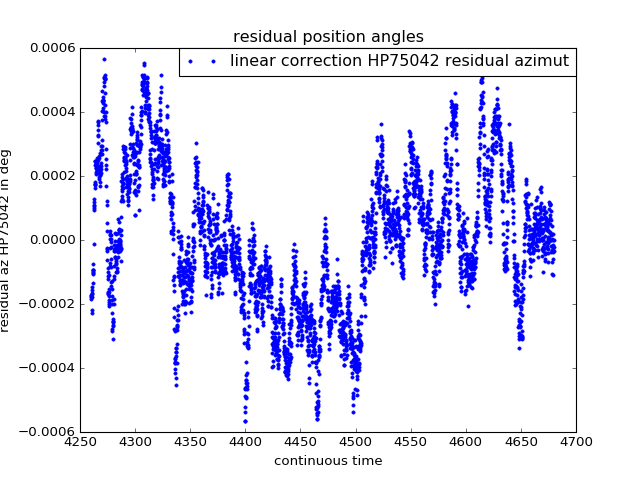

In [97]:
from scipy.optimize import leastsq

thetamp = 10*d2r


# fit a linear correction on AEL & ACE
x, cov, info, msg, ierr = leastsq(lambda x: np.hstack(res(x)), x0, full_output=True )

resAlt, resAz = res(x)
res_var = np.hstack((resAlt,resAz)).var()
cov *= res_var

print(msg)
print("""
Solution:
 El offset:      {} +-{} in deg
 El linear gain: {} +-{}
 CE offset:      {} +-{} in deg
 CE gain:        {} +-{}
 """.format(x[0]/d2r, np.sqrt(cov[0,0])/d2r, x[1], np.sqrt(cov[1,1]), 
                                   x[2]/d2r, np.sqrt(cov[2,2])/d2r, x[3], np.sqrt(cov[3,3])))


print("covariance:\n",cov)

resfitAlt, resfitAz = res(x)

plt.figure()
plt.plot(timesec[time_test], resfitAlt/d2r,'.',label = "linear correction HP75042 residual altitude")
plt.title('residual position angles')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('residual alt HP75042 in deg')

plt.figure()
plt.plot(timesec[time_test], resfitAz/d2r,'.',label = "linear correction HP75042 residual azimut")
plt.title('residual position angles')
plt.legend(loc='upper right', borderaxespad=0.)
plt.xlabel('continuous time')
plt.ylabel('residual az HP75042 in deg')


In [20]:
info

NameError: name 'info' is not defined

### sensitivity of the test

#### to thetamp

In [21]:
thetampshift = 10.3*d2r


# fit a linear correction on AEL & ACE
xshift, covshift, info, msg, ierr = leastsq(lambda x,t: np.hstack(res(x, thetamp=t)), x0, args=thetampshift ,full_output=True )
resAlt, resAz = res(xshift, thetamp=thetampshift)
res_var = np.hstack((resAlt,resAz)).var()
covshift *= res_var

print("""
Solution for a shift of +0.3deg in thetamp:
 El offset,      before: {0} +-{1} in deg / after: {8} +-{9}
 El linear gain, before: {2} +-{3}        / after: {10} +-{11}
 CE offset,      before: {4} +-{5} in deg / after: {12} +-{13}
 CE gain,        before: {6} +-{7}        / after: {14} +-{15}
 """.format(x[0]/d2r, np.sqrt(cov[0,0])/d2r, x[1], np.sqrt(cov[1,1]), 
            x[2]/d2r, np.sqrt(cov[2,2])/d2r, x[3], np.sqrt(cov[3,3]),
            xshift[0]/d2r, np.sqrt(covshift[0,0])/d2r, xshift[1], np.sqrt(covshift[1,1]), 
            xshift[2]/d2r, np.sqrt(covshift[2,2])/d2r, xshift[3], np.sqrt(covshift[3,3]))
     )




ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 1))



NameError: name 'x' is not defined

#### to star position

In [22]:
#alphax_new, alphay_new =  alphax + 10/3600.*d2r, alphay + 10/3600.*d2r
alphax_new, alphay_new =  alphax,  alphay - .5*d2r
#alphax_new, alphay_new =  alphax - .5*d2r,  alphay - .51*d2r

# fit a linear correction on AEL & ACE
func = lambda x,ax,ay: np.hstack(res(x, alphax=ax, alphay=ay))
xshift, covshift, info, msg, ierr = leastsq(func, x0, args=(alphax_new, alphay_new), full_output=True )
resAlt, resAz = res(xshift, alphax=alphax_new, alphay=alphay_new)
res_var = np.hstack((resAlt,resAz)).var()
covshift *= res_var

print("""
Solution for a shift of guiding star position:
 El offset,      before: {0} +-{1} in deg / after: {8} +-{9}
 El linear gain, before: {2} +-{3}        / after: {10} +-{11}
 CE offset,      before: {4} +-{5} in deg / after: {12} +-{13}
 CE gain,        before: {6} +-{7}        / after: {14} +-{15}
 """.format(x[0]/d2r, np.sqrt(cov[0,0])/d2r, x[1], np.sqrt(cov[1,1]), 
            x[2]/d2r, np.sqrt(cov[2,2])/d2r, x[3], np.sqrt(cov[3,3]),
            xshift[0]/d2r, np.sqrt(covshift[0,0])/d2r, xshift[1], np.sqrt(covshift[1,1]), 
            xshift[2]/d2r, np.sqrt(covshift[2,2])/d2r, xshift[3], np.sqrt(covshift[3,3]))
     )



ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 1))



NameError: name 'x' is not defined

In [23]:
# minimize El offset with thetamp variation (degenerated with alphax)
from scipy.optimize import minimize_scalar

def func(thetamp):
    xshift, err = leastsq(lambda x,t: np.hstack(res(x, thetamp=t)), x0, args=(thetamp))
    return xshift[0]**2

thetamp_sol = minimize_scalar(func, bounds=(thetamp-d2r,thetamp+d2r), method='bounded')
print("""
Solution for a shift in thetamp by minimizing El offset:
 thetamp {} in deg""".format(thetamp_sol.x/d2r))
xshift, covshift, info, msg, ierr = leastsq(lambda x,t: np.hstack(res(x, thetamp=t)), x0, args=thetamp_sol.x ,full_output=True )
resAlt, resAz = res(xshift, thetamp=thetamp_sol.x)
res_var = np.hstack((resAlt,resAz)).var()
covshift *= res_var

print("""
 El offset,      before: {0} +-{1} in deg / after: {8} +-{9}
 El linear gain, before: {2} +-{3}        / after: {10} +-{11}
 CE offset,      before: {4} +-{5} in deg / after: {12} +-{13}
 CE gain,        before: {6} +-{7}        / after: {14} +-{15}
 """.format(x[0]/d2r, np.sqrt(cov[0,0])/d2r, x[1], np.sqrt(cov[1,1]), 
            x[2]/d2r, np.sqrt(cov[2,2])/d2r, x[3], np.sqrt(cov[3,3]),
            xshift[0]/d2r, np.sqrt(covshift[0,0])/d2r, xshift[1], np.sqrt(covshift[1,1]), 
            xshift[2]/d2r, np.sqrt(covshift[2,2])/d2r, xshift[3], np.sqrt(covshift[3,3]))
     )




ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 1))




Solution for a shift in thetamp by minimizing El offset:
 thetamp 10.9584361469 in deg


NameError: name 'x' is not defined

In [24]:
# minimize CE offset with alphay variation
from scipy.optimize import minimize_scalar

def func(alphay, thetamp):
    xshift, err = leastsq(lambda x,ay,t: np.hstack(res(x, alphay=ay, thetamp=t)), x0, args=(alphay,thetamp))
    return xshift[2]**2

alphay_sol = minimize_scalar(func, bounds=(alphay-d2r,alphay+d2r), args=(thetamp_sol.x), method='bounded')
print("""
Solution for a shift in alphay by minimizing CE offset:
 alphay {} in arcsec""".format(alphay_sol.x*3600/d2r))
xshift, covshift, info, msg, ierr = leastsq(lambda x,ay,t: np.hstack(res(x, alphay=ay, thetamp=t)), x0, args=(alphay_sol.x,thetamp_sol.x) ,full_output=True )
resAlt, resAz = res(xshift, thetamp=thetamp_sol.x, alphay=alphay_sol.x)
res_var = np.hstack((resAlt,resAz)).var()
covshift *= res_var

print("""
 El offset,      before: {0} +-{1} in deg / after: {8} +-{9}
 El linear gain, before: {2} +-{3}        / after: {10} +-{11}
 CE offset,      before: {4} +-{5} in deg / after: {12} +-{13}
 CE gain,        before: {6} +-{7}        / after: {14} +-{15}
 """.format(x[0]/d2r, np.sqrt(cov[0,0])/d2r, x[1], np.sqrt(cov[1,1]), 
            x[2]/d2r, np.sqrt(cov[2,2])/d2r, x[3], np.sqrt(cov[3,3]),
            xshift[0]/d2r, np.sqrt(covshift[0,0])/d2r, xshift[1], np.sqrt(covshift[1,1]), 
            xshift[2]/d2r, np.sqrt(covshift[2,2])/d2r, xshift[3], np.sqrt(covshift[3,3]))
     )




ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 1))




Solution for a shift in alphay by minimizing CE offset:
 alphay -1728.20717373 in arcsec


NameError: name 'x' is not defined

### Finaly
 * The Elevation slope factor is insensitive (up to 1E-5) to both star position and thetamp (and elevation offset). Thus the correction is **to increase the today CNES Elevation conversion by +0.35%**
 * The Elevation offset is very sensitive to thetamp and alphax (star angle in the field along altitude axis), there is a denegeracy between them since always the sum of both appears in the equations for az,alt of star LOS, we can minimize this offset by changing either thetamp or alphax. We find a **null Eleveation offset for a change of +0.96 deg in thetamp+alphax**.
 This offset sensitivity does not impact the Elevation slope.
 * The Cross-elevation slope is sensitive to the Cross-elevation offset thus to alphay (and not to alphax or thetamp).
  We know that there should not be any CE offset, we can thus search for the alphay which minimize this offset, and then look at the slope. We find **a change in alphay of -1700 arcsec to set the CE elevation offset at zero**. This rather big discrpeancie could also be explained by a bad knowledge of the roll angle of the gondola ?
 * once CE offset reduced to zero with alphay tunning, we find the CE correction is **to reduce the today CNES Cross-Elevation conversion by 5%** 